## Upload functions and necessary modules

In [1]:
from bb2022_functions import *
%matplotlib inline
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import SeqIO
pd.options.mode.chained_assignment = None  # default='warn'

## Import and format metadata

In [2]:
md = pd.read_csv("metadata_merged.csv")
merged = pd.read_csv("metadata_niskin.csv")
all_md = pd.read_csv("allmetadata.csv")

### Visualize metadata

In [ ]:
maxvals = plot_nutrients(all_md, 60)

## Add microbial communities

In [3]:
#generate a dataframe from all specified amplicon
df, comm = consolidate_tables('16S')#, frac='pooled') #16S, chloroplast, or 18S
merged = merge_metadata(df, all_md)
separated, contaminants = pick_metadata(comm, merged)
newseparated = make_defract(all_md, separated)
#apply changes to taxonomy according to NCBI identified ASVs
newdf = apply_replacement(newseparated, "feature_id", "Genus") 
#newdf = apply_replacement(newdf, "feature_id", "PRSpecies") 
# or replace Genus with PRSpecies if dealing with phytoref

Community is 02-PROKs
Found all 16S tables.
Successfully saved all tables.
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos
Saved separated by metadata dataframe.
Community is 02-PROKs
Removed cyanobacteria and chloroplast from 02-PROKs
Values were updated


### Use these lines for analysis of P

In [ ]:
#this is all the weeks and depths which we selected for comparison with P
weeks_depths_with_P = newdf[newdf['size_code'] == 'P'][['weekn', 'depth']].drop_duplicates()
filtered_df = newdf.merge(weeks_depths_with_P, on=['weekn', 'depth']) #filter the original df to only keep those samples
newdf = filtered_df

#### Inspect the dna concentrations, and read depth of samples

In [ ]:
#plot of dna concentrations per sample
dnacon(newdf, depth='all', includeSL=True)

In [ ]:
#rarefaction curves per community
rarefy_curve(comm, newdf)

In [ ]:
copy = newdf[['weekn', 'depth', 'size_code', '[DNA]ng/ul']].drop_duplicates()

In [ ]:
copy

We can also sort the samples by their library size:

In [ ]:
newseparated[['Total','sampleid']].sort_values('Total').drop_duplicates()

#### Explore the taxonomy in the samples and compare

In [ ]:
newdf2 = newdf[newdf['size_code'] != 'L']

In [ ]:
#Produce interactive taxonomic barplots with plotly
phyld, top10d = taxbarplot(comm, newdf, 'Genus', depth=60, topn=10, colrow='size_code')

In [ ]:
#Visualize the static barplots with seaborn, and each size fraction separately
taxonomic_barplots(comm, newdf, [5,60], 'Genus', 21, False)

In [ ]:
taxonomic_barplots_p(comm, newdf, [5,60], 'Genus', 21, True)

In [ ]:
#Generate the heatmap for the top genus from each sample
heatmap_top1(comm, newdf, 'Genus')

In [ ]:
f_id = '25679bd7ae54946d9d7348b7fde04db4'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

In [ ]:
def heatmap_top2(comm, sfd, level):
    if comm == 'chloroplast':
        level = 'PRSpecies'
    else:
        level = level

    # Extract relevant columns and clean data
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth', 'weekn', level]].copy()
    toptaxa.loc[toptaxa[level].isin(['Unassigned', 'uncultured+bacterium', 'g__uncultured']), level] = toptaxa['feature_id']
    toptaxa = toptaxa.drop_duplicates()

    # Aggregate and rank taxa by frequency
    df_agg = toptaxa.groupby(['size_code', level, 'depth', 'weekn']).agg({'feature_frequency': sum}).reset_index()
    df_agg['rank'] = df_agg.groupby(['size_code', 'depth', 'weekn'])['feature_frequency'].rank(method='first', ascending=False)

    # Keep only the top 2 taxa for each group
    topd = df_agg[df_agg['rank'] <= 2].copy()

    # Combine top 2 genera into a single string for each group
    topd[level] = topd[level].str.replace('g__', '', regex=False)
    topd['top2_combination'] = topd.groupby(['size_code', 'depth', 'weekn'])[level].transform(
        lambda x: '+'.join(sorted(x.unique()))
    )

    # Remove duplicates by aggregating the most frequent combination
    topd = topd.groupby(['size_code', 'depth', 'weekn', 'top2_combination']).agg(
        {'feature_frequency': 'sum'}
    ).reset_index()

    # Sort unique top 2 combinations in reverse alphabetical order
    unique_combinations = sorted(topd['top2_combination'].unique(), reverse=True)
    type_dic = {comb: i for i, comb in enumerate(unique_combinations, start=1)}

    topd['comm_type'] = topd['top2_combination'].map(type_dic)

    # Custom row order: 1W, 1SL, 1S, 1L, ..., 60W, 60SL, 60S, 60L
    size_order = ['W', 'SL', 'S', 'L']
    depth_order = [f"{d}{s}" for d in ['1', '5', '10', '30', '60'] for s in size_order]
    topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]
    topd['sc_weekn'] = pd.Categorical(topd['sc_weekn'], categories=depth_order, ordered=True)

    topd = topd.sort_values(['sc_weekn'])

    # Ensure each combination of sc_weekn and weekn is unique before pivoting
    pivot_data = topd.groupby(['sc_weekn', 'weekn'])['comm_type'].first().reset_index()

    # Pivot data for the heatmap
    glue = pivot_data.pivot(index="sc_weekn", columns="weekn", values="comm_type")
    glue = glue[glue.columns].astype(float)

    cmap = plt.get_cmap('tab20', len(type_dic))

    sns.set_style('ticks')
    plt.figure(figsize=(5, 5))

    ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap)

    # Adjust colorbar to display top 2 combinations
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([val + 0.5 for val in range(len(type_dic))])
    colorbar.set_ticklabels(unique_combinations)

    # Add dotted lines for separation
    ax.axhline(4, ls='--')
    ax.axhline(8, ls='--')
    ax.axhline(12, ls='--')
    ax.axhline(16, ls='--')

    # Set x-ticks (e.g., every 5 weeks)
    ax.set_xticks(range(0, 16, 5))
    ax.set_ylabel("Depth and Size Code")
    ax.set_xlabel("Week Number")

    # Save and display the heatmap
    plt.savefig(f'outputs/{comm}/heatmap_top2_fixed_{level}.png', bbox_inches='tight', dpi=300)
    plt.show()


In [ ]:
heatmap_top2(comm, newdf, 'Genus')

In [ ]:
import pandas as pd

def prepare_chord_data(G):
    """
    Prepare co-occurrence data for a chord diagram.
    
    Parameters:
    - G: NetworkX graph object.
    
    Returns:
    - DataFrame: Edge list with source, target, and weight.
    """
    # Extract edges and their weights
    edges = [(u, v, d['count']) for u, v, d in G.edges(data=True)]
    chord_data = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
    return chord_data


In [ ]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

def visualize_chord(chord_data):
    """
    Visualize a chord diagram from co-occurrence data.
    
    Parameters:
    - chord_data: DataFrame containing Source, Target, and Weight columns.
    """
    # Create Chord Diagram
    nodes = list(set(chord_data['Source']).union(set(chord_data['Target'])))
    chords = hv.Chord((chord_data, hv.Dataset(nodes, 'Index')))
    
    # Configure the diagram
    chords = chords.opts(
        opts.Chord(
            labels='Index',
            edge_color='Source',
            edge_cmap='Category20',
            node_color='Index',
            node_cmap='Category20',
            width=800,
            height=800,
            title="Co-occurrence Chord Diagram"
        )
    )
    return chords


The above plot uses taxonomy, but we can generate the same plot but by comparing whether 80% of the features in each samples are also found in the whole (unfractionated samples). This was quantified by dividing the number of shared features by the toal number of features. If a square has a red color (closer to 1), it's very similar to the unfractionated sample, and the bluer the square, the more different it is from the unfractionated.

In [ ]:
grab_80perc(comm, newseparated, 0.8, 'feature_id')

In [5]:
newdf[['size_code']]

,size_code
0,SL
1,SL
2,SL
3,SL
4,SL
...,...
113624,S
113625,S
113626,S
113627,S


We can plot alpha diversity measurements, whether as 'shannon_diversity' or 'nASVs' which is the richness quantified by the total number of ASVs

['SL' 'W' 'L' 'S']


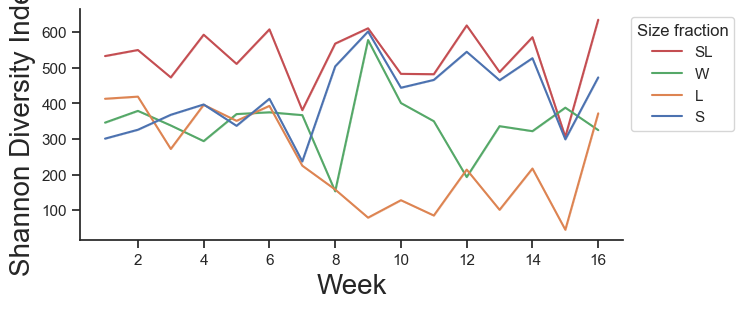

In [33]:
#run the visualisations for alpha diversity and run pairwise t-tests between size fractions for richness values
anova, results = boxplot_depth(newdf, comm, 60, 'nASVs', 'Shannon Diversity Index')
#results gives the corrected p-values for pairwise comparisons

In [34]:
results

,SL,W,L,S
SL,1.000000e+00,0.000018,4.539310e-07,0.010765
W,1.842885e-05,1.000000,3.308731e-02,0.038276
L,4.539310e-07,0.033087,1.000000e+00,0.000844
S,1.076514e-02,0.038276,8.441715e-04,1.000000


Compare the slopes of linear regressions of the richness change over time. Each value represents how much a size fraction (column) differs in comparison to the average slope (averaged between all size fractions) for each depth (rows).

In [ ]:
tohm, z_sc_df = get_slopes(comm, separated)
#a zscore of 1= 1 std away from the mean,
#positive values=higher than mean, neg= smaller than mean

### Venn diagrams for features unique to size fractions

In [ ]:
df_noSL = newdf[newdf['size_code'].isin(['S', 'L', 'W'])]

In [ ]:
df_filtered = newdf[newdf['size_code'].isin(['SL','W']) ]

In [ ]:
df_wide = df_filtered.pivot_table(
    index='feature_id',      # feature_id as the row index
    columns='size_code',     # size_code as column headers
    values='ratio',          # fill column cells with ratio
    fill_value=0             # use 0 where no data is present
) #the reported val

In [ ]:
df_unique_SL = df_wide[(df_wide['SL'] != 0) & (df_wide['W'] == 0)]
df_unique_W  = df_wide[(df_wide['W']  != 0) & (df_wide['SL'] == 0)]

In [ ]:
df_unique_SL.sort_values('SL')

In [ ]:
unique_w_ids = df_unique_W.index

df_w_only_long = newdf[newdf['feature_id'].isin(unique_w_ids)].copy()

df_w_counts = df_w_only_long.groupby(['weekn','depth'])['feature_id'].nunique().reset_index()
df_w_counts.rename(columns={'feature_id':'num_unique_W_features'}, inplace=True)


In [ ]:
df_w_counts.sort_values('num_unique_W_features')

In [ ]:
unique_sl_ids = df_unique_SL.index

df_sl_only_long = newdf[newdf['feature_id'].isin(unique_sl_ids)].copy()

df_sl_counts = df_sl_only_long.groupby(['weekn','depth'])['feature_id'].nunique().reset_index()
df_sl_counts.rename(columns={'feature_id':'num_unique_W_features'}, inplace=True)


In [ ]:
df_w_counts = df_w_only_long.groupby(['weekn','depth'])['feature_id'].nunique().reset_index(name='unique_W')
df_sl_counts = df_sl_only_long.groupby(['weekn','depth'])['feature_id'].nunique().reset_index(name='unique_SL')

df_compare = pd.merge(df_w_counts, df_sl_counts, on=['weekn','depth'], how='outer').fillna(0)

In [ ]:
df_compare.sort_values('unique_SL')

In [ ]:
df_heat_SL = df_compare.pivot(index="depth", columns="weekn", values="unique_SL")

plt.figure(figsize=(6,4))
sns.heatmap(df_heat_SL,
            cmap="viridis")
plt.title("Heatmap of W-Unique Features by depth x weekn")
plt.show()

In [ ]:
df_heat_W = df_compare.pivot(index="depth", columns="weekn", values="unique_W")

plt.figure(figsize=(6,4))
sns.heatmap(df_heat_W,
            cmap="viridis")
plt.title("Heatmap of W-Unique Features by depth x weekn")
plt.show()

In [ ]:
df_totAll = (
    newdf
    .groupby(['weekn','depth'])['feature_id']
    .nunique()
    .reset_index(name='tot_All')
)

In [ ]:
df_totFraction = (
    newdf
    .groupby(['weekn', 'depth', 'size_code'])['feature_id']
    .nunique()               # Count how many distinct ASVs per group
    .reset_index()
    .pivot(index=['weekn','depth'], columns='size_code', values='feature_id')
    .fillna(0)
    .astype(int)
    .rename(columns={'S':'tot_S','L':'tot_L','W':'tot_W','SL':'tot_SL'})
    .reset_index()
)

In [ ]:
df_merged = pd.merge(df_compare, df_totFraction, on=['weekn','depth'], how='left')
df_merged = pd.merge(df_merged, df_totAll,      on=['weekn','depth'], how='left')

In [ ]:
df_merged

In [ ]:
df_merged['propW_inSample']  = df_merged['unique_W']  / df_merged['tot_All']
df_merged['propSL_inSample'] = df_merged['unique_SL'] / df_merged['tot_All']

In [ ]:
df_merged

In [ ]:
df_heatmap = df_merged.pivot(
    index="depth",
    columns="weekn",
    values="propSL_inSample"
)
plt.figure(figsize=(6,4))
sns.heatmap(df_heatmap, cmap="viridis", annot=True)
plt.title("Proportion of Unique-to-W ASVs by Weekn x Depth")
plt.show()

In [ ]:
df_noSL = newdf[newdf['size_code'].isin(['S','L','W'])].copy()

In [ ]:
df_noSL['presence'] = 1

df_pivot = df_noSL.pivot_table(
    index=['weekn', 'depth', 'feature_id'],  # group by these
    columns='size_code',                     # S, L, W become columns
    values='presence',
    fill_value=0,
    aggfunc='sum'  # if duplicates exist, sum them
).reset_index()

In [ ]:
df_pivot['unique_S'] = ((df_pivot['S'] == 1) & (df_pivot['L'] == 0) & (df_pivot['W'] == 0)).astype(int)
df_pivot['unique_L'] = ((df_pivot['L'] == 1) & (df_pivot['S'] == 0) & (df_pivot['W'] == 0)).astype(int)
df_pivot['unique_W'] = ((df_pivot['W'] == 1) & (df_pivot['S'] == 0) & (df_pivot['L'] == 0)).astype(int)

In [ ]:
df_unique_counts = (
    df_pivot
    .groupby(['weekn','depth'])[['unique_S','unique_L','unique_W']]
    .sum()                    # sums the 1/0 across features
    .reset_index()
)


In [ ]:
df_totFraction = (
    df_pivot
    .groupby(['weekn','depth'])[['S','L','W']]
    .sum()  # Because each feature that was present contributes 1
    .reset_index()
    .rename(columns={'S': 'tot_S', 'L': 'tot_L', 'W': 'tot_W'})
)

In [ ]:
df_merged = pd.merge(df_unique_counts, df_totFraction, on=['weekn','depth'], how='left')
df_merged['prop_unique_S'] = df_merged['unique_S'] / df_merged['tot_S']

In [ ]:
df_long = df_unique_counts.melt(
    id_vars=['weekn','depth'],
    value_vars=['unique_S','unique_L','unique_W'],
    var_name='fraction',
    value_name='count_unique'
)

# e.g., fraction might be 'unique_S'. Let's remove "unique_" for clarity:
df_long['fraction'] = df_long['fraction'].str.replace('unique_','')

In [ ]:
g = sns.catplot(
    data=df_long,
    x='weekn', y='count_unique',
    hue='fraction',
    col='depth',      # one subplot per depth
    kind='bar',
    height=4, aspect=1.2
)

g.set_titles("Depth = {col_name}")
g.set_axis_labels("weekn", "Count of Unique Features")
g.add_legend()
plt.suptitle("Number of Fraction-Unique Features by Weekn, Depth", y=1.05)
plt.show()

In [ ]:
df_heat_S = df_unique_counts.pivot(index='depth', columns='weekn', values='unique_S')
df_heat_L = df_unique_counts.pivot(index='depth', columns='weekn', values='unique_L')
df_heat_W = df_unique_counts.pivot(index='depth', columns='weekn', values='unique_W')

sns.heatmap(df_heat_W, annot=True, cmap='Blues')
plt.title("Unique-S Features by (weekn x depth)")
plt.show()


In [ ]:
df_wide_noSL = df_wide[(df_wide['S'] == 0) & (df_wide['L'] == 0)]

In [ ]:
df_SL = df_wide[
    (df_wide['SL'] != 0) & (df_wide['W'] == 0)
]
df_W = df_wide[
    (df_wide['W'] != 0) & (df_wide['SL'] == 0)
]

In [ ]:
len(df_W.index)

In [ ]:
df_SL.sort_values('SL')

In [ ]:
df_SL.to_csv('uniquegenus_to_SL.csv')

In [ ]:
df_W.sort_values('W')

In [ ]:
df_S.sort_values('S').len()

In [ ]:
df_L.sort_values('L')

In [ ]:
f_id = '000527117f05c819fdf7268c540a4a3b'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

In [ ]:
timeseries_fid(comm, newseparated, f_id, 's__uncultured_Alphaproteobacteria', 30)

In [ ]:
newdf.loc[newdf['feature_id'] == f_id]

In [ ]:
newdf

### Beta diversity and ANCOM analysis

Optionally we can run ANCOM with removed low abundance features with a given threshold

In [ ]:
#only if we want to run ANCOM pairwise
news2 = newseparated[newseparated.size_code != 'L']
news2 = news2[news2.size_code != 'SL']

In [ ]:
depths = [1,5,10,30,60]
for depth in depths:
    pca, pca_features, sfdclr, dm = pcaplot(newdf, depth, comm, 'size_code', 'DFr', 'week')

In [ ]:
depths = [1,5,10,30,60]
for depth in depths:
    pca, pca_features, sfdclr, dm = pcaplot(newdf, depth, comm, 'size_code', 'DFr', 'week')
    DAresults, DARejected_SC_taxonomy, prcentile = run_ancom(comm, newdf, sfdclr, depth, 'size_code', threshold=0)

    #save outputs
    DAresults.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_WSLSL.csv')
    DARejected_SC_taxonomy.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_Trueonly_WSLSL.csv')

    notify()

Depending on ancom results, we can investigate single features temporal dynamics

In [ ]:
f_id = 'f3aa3ab8b0d2a94859675d59169af75'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

Visualize the time series of a single feature in each size fraction over the 16 weeks

In [ ]:
timeseries_fid(comm, newseparated, f_id, 'g__Caenarcaniphilales', 1)

In [ ]:
feature_id_summary = count_feature_id_presence_with_depth_and_W('outputs', comm)
top_asvs_summary = filter_top_asvs(feature_id_summary, method="top_W_sum", n=50)
plot_asv_heatmap(comm, feature_id_summary, file_filter="WSLSL")

### Calculate euclidean distance between pairs of samples time-series

In [ ]:
simtable = newdf.loc[newdf['size_code'] != 'L']
simtable = simtable.loc[simtable['size_code'] != 'S']
simtable = simtable.loc[simtable['depth'] == 1] 

In [ ]:
def get_stage(weekNb):
    if weekNb < 8:
        return 'Pre-bloom'
    elif weekNb >= 8:
        return 'Bloom'

simtable['period'] = simtable['weekn'].apply(get_stage)

In [ ]:
simtable = simtable[['sampleid', 'feature_id', 'ratio', 'weekn', 'size_code', 'period']].drop_duplicates()

for calculation correlation for pre- and bloom

In [ ]:
simtable = simtable.pivot(index=['feature_id', 'weekn', 'period'], columns='size_code', values='ratio').reset_index()

In [ ]:
simtable['SL'].fillna(0, inplace=True)
simtable['W'].fillna(0, inplace=True)
simtable['Difference'] = (simtable['SL'] - simtable['W']).abs()

In [ ]:
simtable['Average_Abundance'] = simtable[['SL', 'W']].mean(axis=1)
simtable['Category'] = simtable['Average_Abundance'].apply(lambda x: 'Abundant' if x > 0.01 else 'Rare')

In [ ]:
abundant = simtable[simtable['Category'] == 'Abundant']
rare = simtable[simtable['Category'] == 'Rare']

abundant_correlation = abundant[['SL', 'W']].corr(method='pearson')
rare_correlation = rare[['SL', 'W']].corr(method='pearson')

print("Abundant taxa correlation:\n", abundant_correlation)
print("Rare taxa correlation:\n", rare_correlation)

for comparing clr ratios

In [ ]:
pivoted = simtable.pivot(index='sampleid', columns='feature_id', values='ratio')
pivoted.fillna(1e-6, inplace=True)
#clr from skikit bio
clr_transformed = clr(pivoted)
#prepare df to merge back
clr_df = pd.DataFrame(clr_transformed, index=pivoted.index, columns=pivoted.columns)
clr_long = clr_df.reset_index().melt(id_vars='sampleid', var_name='feature_id', value_name='clr_ratio')
simtable = pd.merge(simtable, clr_long, on=['sampleid', 'feature_id'])

In [ ]:
clr_median = simtable.groupby('feature_id')['clr_ratio'].transform('median')
simtable['Category'] = ['Abundant' if clr >= median else 'Rare' for clr, median in zip(simtable['clr_ratio'], clr_median)]

In [ ]:
simtable

In [ ]:
copy = simtable[['feature_id', 'Average_Abundance']].drop_duplicates()

In [ ]:
copy['Grouped_avg'] = copy.groupby('feature_id')['Average_Abundance'].transform('mean')
copy = copy [['feature_id', 'Grouped_avg']].drop_duplicates()

In [ ]:
copy.sort_values('Grouped_avg')

In [ ]:
def taxonomic_barplot_with_separate_legend(df, level, n=15, include_other=True):
    """
    Creates a grouped stacked barplot showing samples grouped by weekn+depth,
    with size codes (W, SL, P) displayed within each group, ordered by weekn and depth.
    The legend is saved as a separate vertical figure.

    Parameters:
        df (pd.DataFrame): DataFrame with columns: sampleid, size_code, genus, ratio, weekn, depth.
        level (str): Taxonomic level to group by (e.g., genus, species).
        n (int): Number of most abundant taxa to display (others grouped under 'Other').
        include_other (bool): Whether to group less abundant taxa into "Other".
    """
    # Filter size codes to include only W, SL, P
    df = df[df['size_code'].isin(['W', 'SL', 'P'])]

    # Create a new column for weekn+depth combination
    df['weekn_depth'] = df['weekn'].astype(str) + "_" + df['depth'].astype(str)

    # Replace "Unassigned" or "uncultured+bacterium" at the given level with its 'feature_id'
    df[level] = df.apply(
        lambda row: row['genus'] if row[level] in ['Unassigned', 'uncultured+bacterium', 'c__uncultured', 'g__uncultured'] else row[level],
        axis=1
    )

    # Aggregate data globally to find the most abundant taxa
    global_abundance = df.groupby(level)['ratio'].sum().sort_values(ascending=False)

    # Select the top n most abundant taxa globally
    top_taxa = global_abundance.head(n - 1).index.tolist()

    if include_other:
        # Group less abundant taxa into "Other"
        df['plot_taxa'] = df[level].apply(lambda x: x if x in top_taxa else 'Other')
        unique_taxa = ['Other'] + top_taxa
    else:
        df = df[df[level].isin(top_taxa)]
        df['plot_taxa'] = df[level]
        unique_taxa = top_taxa

    # Format taxa labels for the legend (remove prefixes and "__")
    def format_taxa_label(taxon):
        return taxon.split("__")[-1]

    # Create a global discrete color palette for taxa
    color_palette = plt.get_cmap('tab20').colors
    color_dict = {taxon: color_palette[i % len(color_palette)] for i, taxon in enumerate(unique_taxa)}

    # Group by weekn_depth, size_code, and taxa for plotting
    phyld = df.groupby(['weekn', 'depth', 'size_code', 'plot_taxa'])['ratio'].sum().reset_index()

    # Pivot the DataFrame for stacked bar plotting
    phyld_pivot = phyld.pivot(index=['weekn', 'depth', 'size_code'], columns='plot_taxa', values='ratio').fillna(0).reset_index()

    # Order size codes as W, SL, P
    size_code_order = {'W': 0, 'SL': 1, 'P': 2}
    phyld_pivot['size_code_order'] = phyld_pivot['size_code'].map(size_code_order)

    # Sort the data by weekn (ascending), depth (ascending), and size_code (W, SL, P)
    phyld_pivot = phyld_pivot.sort_values(by=['weekn', 'depth', 'size_code_order'])

    # Generate x-axis positions with spacing between weekn_depth groups
    x_positions = []
    labels = []
    current_x = 0
    for (weekn, depth) in phyld_pivot[['weekn', 'depth']].drop_duplicates().values:
        group_data = phyld_pivot[(phyld_pivot['weekn'] == weekn) & (phyld_pivot['depth'] == depth)]
        x_group = np.arange(len(group_data)) + current_x
        x_positions.extend(x_group)
        labels.extend(group_data['weekn'].astype(str) + "_" + group_data['depth'].astype(str) + " (" + group_data['size_code'] + ")")
        current_x += len(group_data) + 1  # Add a gap between groups

    # Initialize stack heights
    bottom_stack = np.zeros(len(x_positions))

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Iterate over each taxon and stack their relative abundances
    taxa_categories = phyld_pivot.columns[3:-2]  # Skip 'weekn', 'depth', 'size_code', 'size_code_order'
    for taxon in taxa_categories:
        heights = phyld_pivot[taxon].values
        ax1.bar(
            x_positions,
            heights,
            bottom=bottom_stack,
            alpha=0.8,
            color=color_dict.get(taxon, 'gray')
        )
        bottom_stack += heights

    # Customize x-axis
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)
    ax1.set_ylabel("Relative Abundance", fontsize=14)
    ax1.set_xlabel("Weekn_Depth (Size Code)", fontsize=14)
    ax1.tick_params(axis='y', labelsize=12)

    # Save the main plot without a legend
    plt.tight_layout()
    plt.savefig(f'outputs/taxonomic_barplot_no_legend.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(3, len(unique_taxa) * 0.5))  # Adjust size based on the number of taxa
    legend_handles = [
        plt.Line2D([0], [0], color=color_dict[taxon], lw=10, label=format_taxa_label(taxon))
        for taxon in unique_taxa
    ]
    fig_legend.legend(
        handles=legend_handles,
        loc="center",
        frameon=False,
        ncol=1,
        title=level,
        fontsize=10
    )
    plt.tight_layout()
    plt.savefig(f'outputs/taxonomic_barplot_legend.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
taxonomic_barplot_with_separate_legend(newdf, 'Genus', n=15, include_other=False)

In [ ]:
def taxonomic_barplots_by_depth(df, level, n=15, include_other=True):
    """
    Creates separate barplots for each depth, with consistent x-axis (weekn).
    Missing data for a specific weekn is left blank.

    Parameters:
        df (pd.DataFrame): DataFrame with columns: sampleid, size_code, genus, ratio, weekn, depth.
        level (str): Taxonomic level to group by (e.g., genus, species).
        n (int): Number of most abundant taxa to display (others grouped under 'Other').
        include_other (bool): Whether to group less abundant taxa into "Other".
    """
    # Filter size codes to include only W, SL, P
    df = df[df['size_code'].isin(['W', 'SL', 'P'])]

    # Replace "Unassigned" or "uncultured+bacterium" at the given level with its 'feature_id'
    df[level] = df.apply(
        lambda row: row['genus'] if row[level] in ['Unassigned', 'uncultured+bacterium', 'c__uncultured', 'g__uncultured'] else row[level],
        axis=1
    )

    # Aggregate data globally to find the most abundant taxa
    global_abundance = df.groupby(level)['ratio'].sum().sort_values(ascending=False)

    # Select the top n most abundant taxa globally
    top_taxa = global_abundance.head(n - 1).index.tolist()

    if include_other:
        # Group less abundant taxa into "Other"
        df['plot_taxa'] = df[level].apply(lambda x: x if x in top_taxa else 'Other')
        unique_taxa = ['Other'] + top_taxa
    else:
        df = df[df[level].isin(top_taxa)]
        df['plot_taxa'] = df[level]
        unique_taxa = top_taxa

    # Format taxa labels for the legend (remove prefixes and "__")
    def format_taxa_label(taxon):
        return taxon.split("__")[-1]

    # Create a global discrete color palette for taxa
    color_palette = plt.get_cmap('tab20').colors
    color_dict = {taxon: color_palette[i % len(color_palette)] for i, taxon in enumerate(unique_taxa)}

    # Get all unique weekn values (for consistent x-axis across plots)
    all_weekn = sorted(df['weekn'].unique())

    # Group by depth and create separate plots
    for depth in sorted(df['depth'].unique()):
        # Filter data for the current depth
        depth_df = df[df['depth'] == depth]

        # Group by weekn, size_code, and taxa for plotting
        phyld = depth_df.groupby(['weekn', 'size_code', 'plot_taxa'])['ratio'].sum().reset_index()

        # Pivot the DataFrame for stacked bar plotting
        phyld_pivot = phyld.pivot(index=['weekn', 'size_code'], columns='plot_taxa', values='ratio').fillna(0).reset_index()

        # Order size codes as W, SL, P
        size_code_order = {'W': 0, 'SL': 1, 'P': 2}
        phyld_pivot['size_code_order'] = phyld_pivot['size_code'].map(size_code_order)
        phyld_pivot = phyld_pivot.sort_values(by=['weekn', 'size_code_order'])

        # Ensure all weekn are included in the plot
        all_weekn_data = []
        for weekn in all_weekn:
            weekn_data = phyld_pivot[phyld_pivot['weekn'] == weekn]
            if weekn_data.empty:
                # Add empty rows for missing weekn
                for size_code in ['W', 'SL', 'P']:
                    all_weekn_data.append({'weekn': weekn, 'size_code': size_code, **{taxon: 0 for taxon in unique_taxa}})
            else:
                all_weekn_data.extend(weekn_data.to_dict('records'))

        # Create a consistent DataFrame for the depth
        consistent_df = pd.DataFrame(all_weekn_data)

        # Generate x-axis positions with consistent weekn
        consistent_df['x_label'] = consistent_df['weekn'].astype(str) + " (" + consistent_df['size_code'] + ")"
        x_positions = range(len(consistent_df))

        # Initialize stack heights
        bottom_stack = np.zeros(len(x_positions))

        # Initialize the plot
        fig, ax1 = plt.subplots(figsize=(18, 8))

        # Iterate over each taxon and stack their relative abundances
        taxa_categories = [col for col in consistent_df.columns if col not in ['weekn', 'size_code', 'size_code_order', 'x_label']]
        for taxon in taxa_categories:
            heights = consistent_df[taxon].values
            ax1.bar(
                x_positions,
                heights,
                bottom=bottom_stack,
                alpha=0.8,
                color=color_dict.get(taxon, 'gray'),
                label=format_taxa_label(taxon)
            )
            bottom_stack += heights

        # Customize x-axis
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(consistent_df['x_label'], rotation=90, ha='center', fontsize=10)
        ax1.set_ylabel("Relative Abundance", fontsize=14)
        ax1.set_xlabel(f"Weekn (Size Code) - Depth {depth}m", fontsize=14)
        ax1.tick_params(axis='y', labelsize=12)

        # Save the plot for the current depth
        plt.tight_layout()
        plt.savefig(f'outputs/taxonomic_barplot_depth_{depth}m.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(3, len(unique_taxa) * 0.5))  # Adjust size based on the number of taxa
    legend_handles = [
        plt.Line2D([0], [0], color=color_dict[taxon], lw=10, label=format_taxa_label(taxon))
        for taxon in unique_taxa
    ]
    fig_legend.legend(
        handles=legend_handles,
        loc="center",
        frameon=False,
        ncol=1,
        title=level,
        fontsize=10
    )
    plt.tight_layout()
    plt.savefig(f'outputs/taxonomic_barplot_legend.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
taxonomic_barplots_by_depth(newdf, 'Genus', n=15, include_other=False)

In [ ]:
filtered_rows = newdf[newdf['sampleid'] == 'BB22.10C']  # or use ~df['column2'].isnull()

In [ ]:
filtered_rows[['sampleid', 'Taxon', 'Family', 'Genus', 'ratio', 'feature_frequency', '[DNA]ng/ul']]

In [ ]:
newdf

### Export files

#### Files for NCBI

To generate MIMARKS file for NCBI sequence submission; the output is a .csv file for the samples and their metadata for submission (i.e sampleid, size fraction, date)

In [ ]:
make_MIMARKS(newseparated)

#### Files for R

To create a phyloseq object, you need an ASV table, taxonomy file and metadata

In [ ]:
filtered_data = newdf[['size_code', 'feature_id', 'ratio', 'Phylum', 'Genus', 'Family', 'Class']]
filtered_data = newdf[newdf['size_code'].isin(['S', 'W', 'L'])]

# Identify unshared ASVs for each size fraction
unshared_asvs = filtered_data.groupby('size_code').apply(
    lambda group: group.loc[~group['feature_id'].isin(
        filtered_data.loc[filtered_data['size_code'] != group.name, 'feature_id']
    )]
).reset_index(drop=True)

sizecodes = ['S', 'L', 'W']
palette_colors = sns.color_palette()
palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

sns.set_theme(style='ticks')
sns.despine()
sns.displot(
    data=unshared_asvs,
    x='ratio',
    hue='size_code',
    kind='hist',
    multiple='stack',  # Bars are side-by-side
    palette=palette_dict,
    log_scale=(True, False),
    height=4, aspect=1.1,
    legend=False,
    bins=25
)


plt.xlabel('log(Ratio)', fontsize=14, weight='bold')
plt.ylabel('Number of features', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/"+comm+"/displot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
filtered_data = newdf[['size_code', 'feature_id', 'ratio', 'Phylum', 'Genus', 'Family', 'Class']]
filtered_data = newdf[newdf['size_code'].isin(['S', 'W', 'L'])]

# Identify unshared ASVs for each size fraction
unshared_asvs = filtered_data.groupby('size_code').apply(
    lambda group: group.loc[~group['feature_id'].isin(
        filtered_data.loc[filtered_data['size_code'] != group.name, 'feature_id']
    )]
).reset_index(drop=True)

sizecodes = ['S', 'L', 'W']
palette_colors = sns.color_palette()
palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

sns.set_theme(style='ticks')
sns.despine()
sns.displot(
    data=unshared_asvs,
    x='ratio',
    hue='Phylum',
    kind='hist',
    multiple='stack',  # Bars are side-by-side,
    log_scale=(True, False),
    height=4, aspect=1.1,
    bins=25
)


plt.xlabel('log(Ratio)', fontsize=14, weight='bold')
plt.ylabel('Number of features', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig("outputs/"+comm+"/displot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
sns.set_theme(style='ticks')
sns.despine()
sns.displot(
    data=unshared_asvs,
    x='ratio',
    hue='size_code',
    kind='hist',
    multiple='stack',  # Bars are side-by-side
    palette=palette_dict,
    height=4, aspect=1.1,
    legend=False
#    ,bins=600
)

#plt.xlim(0, 0.1)
plt.xlabel('Ratio', fontsize=14, weight='bold')
plt.ylabel('Number of features', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("outputs/"+comm+"/displot_nolog.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
def dnacon(newseparated, depth='all'):
    # Filter by depth if needed
    if depth != 'all':
        df = newseparated[newseparated.depth == depth]
    else:
        df = newseparated

    # Sort and filter the data
    sorted_data = df[["weekn", "[DNA]ng/ul", "size_code", 'depth', 'date']].sort_values(by=["weekn", "size_code", 'depth'])
    filtered_df = sorted_data[sorted_data["size_code"] != "SL"]

    # Calculate the SL value as S + L
    sl_data = (
        filtered_df[filtered_df["size_code"].isin(["S", "L"])]
        .groupby(["weekn", "depth", "date"], as_index=False)["[DNA]ng/ul"]
        .sum()
    )
    sl_data["size_code"] = "SL"

    # Append the SL data back to the original filtered dataframe
    updated_df = pd.concat([filtered_df, sl_data], ignore_index=True)

    # Drop duplicates and sort
    updated_df = updated_df.drop_duplicates().sort_values(by=["weekn", "size_code", 'depth'])

    # Define color palette for the size codes
    sizecodes = ['S', 'L', 'W', 'SL', 'P']
    palette_colors = sns.color_palette()
    palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=updated_df,
        x="date",
        y="[DNA]ng/ul",
        hue="size_code",
        palette=palette_dict
    )

    plt.xlabel("Time", fontsize=12)
    plt.ylabel("DNA Concentration (ng/µl)", fontsize=12)
    plt.legend(title="Size Code", fontsize=10, title_fontsize=12)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)

    # Display and save the plot
    plt.tight_layout()
    plt.savefig("outputs/grouped_bar_dnaconc" + str(depth) + ".png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
# Group by 'weekn', 'depth', and 'date' to calculate the sum of 'S' and 'L'
sl_fill_values = (
    newseparated[newseparated["size_code"].isin(["S", "L"])]
    .groupby(["weekn", "depth", "date"], as_index=False)["[DNA]ng/ul"]
    .sum()
)

# Add a column to identify these as 'SL'
sl_fill_values["size_code"] = "SL"

# Merge the sum values back into 'newseparated' to fill the NaN rows for 'SL'
newseparated.loc[
    (newseparated["size_code"] == "SL") & (newseparated["[DNA]ng/ul"].isna()),
    "[DNA]ng/ul",
] = newseparated.merge(
    sl_fill_values,
    on=["weekn", "depth", "date", "size_code"],
    how="left"
)["[DNA]ng/ul_y"]

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Filter the data for size codes SL and W
sl_data = newseparated[newseparated['size_code'] == 'SL']
w_data = newseparated[newseparated['size_code'] == 'W']

# Merge the data to align SL and W for the same feature_id, weekn, and depth
merged_data = pd.merge(
    sl_data, 
    w_data, 
    on=["feature_id", "weekn", "depth"], 
    suffixes=('_sl', '_w')
)

# List to store correlation results
correlation_results = []

# Calculate the Pearson correlation for each feature_id
for feature in merged_data['feature_id'].unique():
    # Filter rows for the current feature
    feature_data = merged_data[merged_data['feature_id'] == feature]
    
    # Extract the SL and W ratios
    sl_series = feature_data['ratio_sl']
    w_series = feature_data['ratio_w']
    
    # Ensure there are enough data points for correlation
    if len(sl_series) > 1 and len(w_series) > 1:  # At least 2 points
        correlation, _ = pearsonr(sl_series, w_series)  # Pearson correlation
        
        # Calculate mean ratios for SL and W
        mean_ratio_sl = sl_series.mean()
        mean_ratio_w = w_series.mean()
        
        # Add correlation and metadata to the results list
        correlation_results.append({
            'feature_id': feature,
            'correlation': correlation,
            'depth': feature_data['depth'].iloc[0],  # Assume depth is constant for a feature
            'mean_ratio_sl': mean_ratio_sl,
            'mean_ratio_w': mean_ratio_w
        })

# Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Sort the DataFrame by correlation score
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

# Extract the best and worst matches
top_n_best_df = correlation_df.head(10)  # Top 10 best matches
top_n_worst_df = correlation_df.tail(10)  # Top 10 worst matches

# Display the best and worst matches
print("Top 10 Best Matches:")
print(top_n_best_df)
print("\nTop 10 Worst Matches:")
print(top_n_worst_df)

# Save to CSV if needed
correlation_df.to_csv('correlation_results.csv', index=False)
top_n_best_df.to_csv('best_matches.csv', index=False)
top_n_worst_df.to_csv('worst_matches.csv', index=False)

In [ ]:
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

In [ ]:
correlation_df.sort_values('correlationé')

In [ ]:
f_id = 'd93e9fdee1043924e16705e2be0f1912'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

In [ ]:
timeseries_fid(comm, newseparated, f_id, 'g__Clade_Ia', 5)